## Simple residual base

### Data Preparation

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2024-07-10 17:58:42.891363: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-10 17:58:42.891398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Reading Data
dir_name="../../data/member_001"

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2=read_xarray(dir_name)

mld=mld.isel(bnds=0)
sss=sss.isel(bnds=0)
sst=sst.isel(bnds=0)
xco2=xco2.isel(bnds=0)


mld['time'] =mld.time.indexes['time'].to_datetimeindex()
sss['time'] =sss.time.indexes['time'].to_datetimeindex()
sst['time'] =sst.time.indexes['time'].to_datetimeindex()
xco2['time'] =xco2.time.indexes['time'].to_datetimeindex()

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/local/ipykernel_3911667/3409989473.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mld['time'] =mld.time.indexes['time'].to_datetimeindex()
/local/ipykernel_3911667/3409989473.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sss['time'] =sss.time.indexes['time'].to_datetimeindex()
/local/ipykernel_3911667/34

In [3]:

pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")
xco2['time'] =xco2.time.dt.strftime("%Y-%m")

In [4]:
# Creating one singular df
data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])

In [5]:
tmp_data=data_read.to_dataframe().reset_index()
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

In [6]:
# tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
# tmp_data["Chl"]=chl_data["Chl"]
# tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
# tmp_data["pCO2"]=pco2_data["pCO2"]

In [7]:
check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()

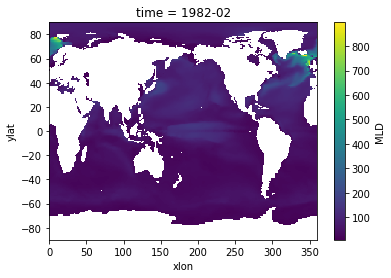

In [8]:
check.MLD[1].plot()

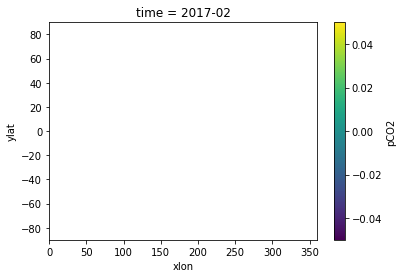

In [9]:
check.pCO2[421].plot()

In [10]:
tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

In [11]:
features_socat = ['time','xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

In [13]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
combined.head()

,time,xlon,ylat,SST,SSS,Chl,XCO2,pCO2
64820,1982-02,0.5,-69.5,-1.552322,33.641834,0.064728,340.848541,259.943180
64821,1982-02,0.5,-68.5,-1.626047,33.667816,0.079743,340.848541,264.257161
64822,1982-02,0.5,-67.5,-1.607591,33.572289,0.077933,340.848541,269.302537
64823,1982-02,0.5,-66.5,-1.496069,33.424641,0.069886,340.848541,275.715089
64824,1982-02,0.5,-65.5,-1.207762,33.317802,0.060309,340.848541,285.947764


In [15]:
combined_socat.isna().sum()

time          0
xlon          0
ylat          0
SST_socat     0
SSS_socat     0
Chl_socat     0
XCO2          0
pCO2_socat    0
dtype: int64

In [16]:
#separating X and y
X_socat=combined_socat.iloc[:,1:-1]
X=combined.iloc[:,1:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


In [17]:
combined.xlon.min(),combined.xlon.max(),combined.ylat.min(),combined.ylat.max()

(0.5, 359.5, -77.5, 89.5)

In [18]:
# Two Different Imputation Methods

# KNNImputer
# from sklearn.impute import KNNImputer
# imp = KNNImputer(n_neighbors=2)
# X=imp.fit_transform(X)
# X_socat=imp.fit_transform(X_socat)

# SimpleImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

### Modeling - Residual

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)

regressor=LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression()

In [21]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
res_scores = cross_val_score(regressor, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
res_rmse_scores = np.sqrt(-res_scores)

display_scores(res_rmse_scores)

Scores: [36.37149691 35.98416257 36.26597922]
Mean: 36.207212899057296
Standard deviation: 0.1634973653944182


### Final Result: full

Socat RMSE: 

Whole Grid Rmse: 

In [22]:
# On Socat
y_pred=regressor.predict(X_socat)
test_mse=mean_squared_error(y_socat, y_pred,squared=True)
np.sqrt(test_mse)

36.2518433389306

In [24]:
## The whole grid
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred
final_test_rmse

36.49143734190393

### Modeling - Residual Full


Uses train_test_split build into sklearn.model_selection


By default this method shuffles the data (30% = testing 70%=training/validation)
- Will test validation via 7-fold cross validation

Train  = 70%, Test   = 30%

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)


In [26]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

regressor=LinearRegression()
regressor.fit(X_train, y_train)

res_scores = cross_val_score(regressor, X_train, y_train, scoring="neg_mean_squared_error", cv=7)
res_rmse_scores = np.sqrt(-res_scores)

In [27]:
display_scores(res_rmse_scores)

Scores: [36.57447414 36.10593454 36.16058004 35.97150581 36.15755403 36.17920356
 36.30181749]
Mean: 36.20729566074153
Standard deviation: 0.1752838886865018


### Final Result

In [28]:
y_pred=regressor.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

36.35907323966935

In [29]:
## The whole grid
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred
final_test_rmse

In [38]:
## Train/test results
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X, y, test_size=0.3, random_state= 73)
print(np.sqrt(mean_squared_error(y_full_train, regressor.predict(X_full_train), squared=True)))
print(np.sqrt(mean_squared_error(y_full_test, regressor.predict(X_full_test), squared=True)))

36.49985658864296
36.47178487470613


### Visualization of the Residual

In [31]:
combined["residual"] = error

In [32]:
combined["pred"] = y_pred

In [33]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()


In [34]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()

In [35]:
ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

(array([6.000000e+00, 3.600000e+01, 5.120000e+02, 3.844000e+03,
        1.277800e+04, 4.182900e+04, 1.437070e+05, 4.410010e+05,
        1.715850e+06, 4.704571e+06, 5.627361e+06, 3.164247e+06,
        7.852180e+05, 3.117100e+05, 1.487990e+05, 6.954600e+04,
        3.175300e+04, 1.630100e+04, 8.214000e+03, 5.573000e+03,
        4.414000e+03, 3.543000e+03, 2.854000e+03, 2.212000e+03,
        1.670000e+03, 1.009000e+03, 5.320000e+02, 2.310000e+02,
        6.800000e+01, 1.100000e+01]),
 array([-252.4190941 , -227.45955777, -202.50002144, -177.54048511,
        -152.58094878, -127.62141245, -102.66187612,  -77.70233979,
         -52.74280346,  -27.78326713,   -2.82373081,   22.13580552,
          47.09534185,   72.05487818,   97.01441451,  121.97395084,
         146.93348717,  171.8930235 ,  196.85255983,  221.81209616,
         246.77163248,  271.73116881,  296.69070514,  321.65024147,
         346.6097778 ,  371.56931413,  396.52885046,  421.48838679,
         446.44792312,  471.40745945, 

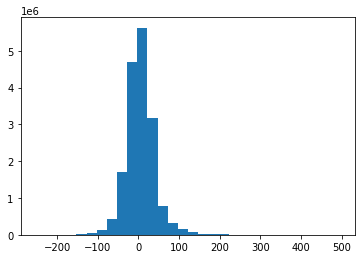

In [36]:
plt.hist(error,bins=30)

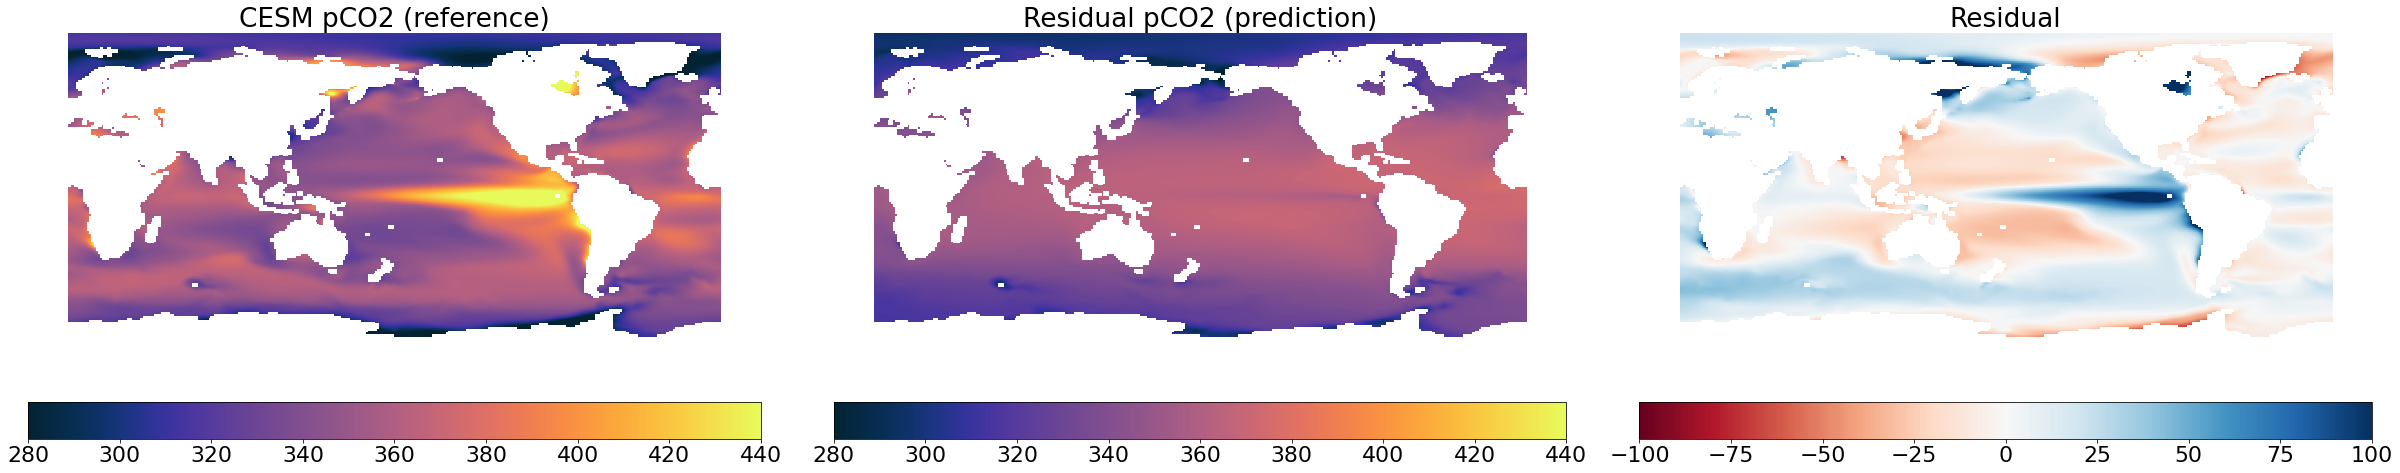

In [37]:
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

im0 = axis[0].imshow(np.flipud(ds_pred.pCO2.mean('time').data),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("CESM pCO2 (reference)")
axis[0].axis('off')

im1 = axis[1].imshow(np.flipud(ds_pred.pred.mean('time').data),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("Residual pCO2 (prediction)")
axis[1].axis('off')


norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im2 = axis[2].imshow(np.flipud(ds.residual.mean('time').data),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average CESM RF pCO2 | Prediction | Residual - 1987/02-2017/01")
# plt.savefig("../../assets/figure2.2_rf_socat.jpg", dpi=200)